In [1]:
# Prerequisites
import numpy as np
from numpy import log
from numpy import random as rd
from PIL import Image
import matplotlib.pyplot as plt
from tifffile import imwrite, imread
import configparser
from scipy.spatial.transform import Rotation

# Our classes
from BooleanModel import CBooleanModel, Render3DImage
from DirectionalDistributions import CRotationGenerator
from Particles import CParticle

# Introduction
There exist a variety of different models that can be used to generate synthetic data. On a basic level we distinguish between deterministic and random models. Deterministic models may seem appealing at first due to their simplistic nature and lack of randomness. However, real structures usually exhibit microscopic heterogeneity that cannot be captured by deterministic models.

One the most commonly encountered classes of random models are called 'germ-grain' models. In line with their name, they can be decomposed into two separate processes. Initially, points/positions (germs) are sampled in space. For each sampled germ a corresponding body/set (grain) is sampled and attached to the germ. In the following, we want to test out this procedure on a simple example.

Peter has recently started with archery and manages to consistenly hit an square area of 2x2 meters with the target of radius 1 meter at its center. However, he is not a very good archer and his shots land at random inside of this area. Ingoring the bulls-eye each ring has a width of 10cm and counting from the outside awards 1 to 10 points when hit. A miss rewards no points. 

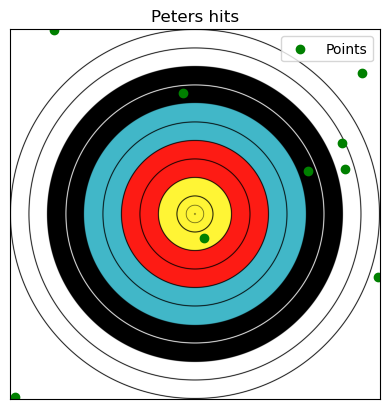

Peter shot 9 arrows at the target.
5 arrows hit the target and scored a total of 21.0 points.
His individual scores were [2 4 4 2 0 0 0 0 9].


In [2]:
lmb = 10

number_of_germs = rd.poisson(lmb)
# Sampling of germ locations in 2D space
points = rd.random((number_of_germs,2))

# Load the image
image_path = 'Notebook-Images/ArcheryTarget.png'  # Replace with the path to your image
image = Image.open(image_path)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image as the background
ax.imshow(image, extent=[0, image.width, 0, image.height])

# Plot the points on top of the image
ax.scatter(image.width*points[:, 0], image.height*points[:, 1], color='green', marker='o', label='Points')

# Set labels and title
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Peters hits')

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Counting score
scores = np.maximum(10 - np.floor(np.linalg.norm(20*points-10,axis=1)),0)
print(f'Peter shot {number_of_germs} arrows at the target.\n{np.count_nonzero(scores.astype(int))} arrows ' + \
      f'hit the target and scored a total of {np.sum(scores)} points.\nHis individual scores were {scores.astype(int)}.')

You may have noticed, but for visualizing Peters hits on the board, we used green markers. This depicts already a germ-grain process where germs are the locations of Peter's arrow hits and green dots are the grains which are attached to the locations. In this instance, the grain process is simply constant.

With this initial example in mind, we can dive into further detail with the models used in our project. These include so-called 'Boolean models' which are germ-grain models which satisfy:
* the number of germs in an space $A\subset\mathbb{R}^d$ is a Poisson-distributed random variable with intensity $\lambda(A)$.
* grains are drawn independent of the germs.

The intensity $\lambda$ of the Poisson distribution corresponds to the expected number of germs per unit volume. **Play around with the parameter *lmb* and very this yourself.** The amount of points will often be 'close' but can sometimes deviate significantly.


Note, that $\lambda$ does not necessarily have to be a constant, but can be dependent on the position in space. However, since many structures appear homogeneous on a small enough scale $\lambda$ is typically left constant. In this instance, homogeneous refers to the property that no matter where in space we look, the overall structure is indistinguishable from other location.

*Further details: Boolean models are quite a big restriction towards germ-grain models. However, they offer knowledge on the expected value of geometrical quantities such as the volume, surface area, mean curvature and mean width. This information can be of use when analyzing the structures and its properties, e.g., for flow of water through the geometry. None the less, if we want to extend towards more general germ-grain processes, we can modify the underlying germ-process to consider interactions between sampled germs such that clustering or repulsion can be achieved. Common examples for this are Strauss or hard-core processes.*

# Synthetic Data of Geometrical Structures
In our case, we are interested in material structures such as foames or particles systems. These can usually be modelled and approximated using Boolean models. Below you can find a small range of examples that can be generated by using Boolean models. We distinguish explicitly between different shapes of particles. However, a combination of different particle types or distributions is straight-forward. If you take a look at the images, what properties and behaviours can you spot?

* What can you tell about the size of particles? Are there any differences across the individual images?
* What about directions? Can you tell apart what kind of directional distributions were used in the generating process?

*If you are interested, use Fiji (ImageJ) to look into the images in more detail. You can scroll through the slices, or use the 3D image viewer (Plugins -> 3D Viewer) where you rotate using the middle mouse button.*
<table><tr>
<td><img src="Notebook-Images/Sphere_Vv06_r15-30_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_Uniform-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_vMF20-Crop.png" style="width: 200px;"/></td>
</tr></table>
<table><tr>
<td><img src="Notebook-Images/Sphere_Vv06_r20-40_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_Uniform-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_vMF20-Crop.png" style="width: 200px;"/></td>
</tr></table>

In our current implementation, we are able to combine the following different aspects and corresponding settings:
* Volume density $\in[0,1]$
* Particle shape (sphere,cube,cylinder,ellipsoid,cuboid)
* Distribution of particle size (constant,uniform)
* Particle size (1/2 for sphere and cube, 2/4 for cylinder and 3/6 for ellipsoid and cuboid, in all cases a 3x2 array should be given)
* Orientation distribution (fixed, von Mises-Fisher, Schladitz/Gaussian, uniform)
* Edge treatment option (plus sampling,periodic)

To understand all options, we are going to discuss them one-by-one. 

## Volume Density
One of the simplest, yet strongly differentiating properties of structures is the volume density ($V_V$). It is the average ratio of space filled by the geometry, i.e., $V_V=0.6$ implies that 60\% of the available space is occupied by the geometry while the rest of it is empty. **Try out different values of $V_V$ in the range $(0,1)$.** Observe, how the structure changes.

*Further details: We are using vtk to render the image in 3D. You can rotate the structure around by holding down left-click on your mouse.*

In [3]:
Vv = 0.1
# Setting up the Boolean Model Class
Model = CBooleanModel(volume_density=Vv,
                      image_size=np.array([256,256,256]),
                      particle_shape='Sphere',
                      particle_parameters=np.array([[30,50],[0,0],[0,0]]),
                      particle_distribution='Uniform',
                      edge_treatment='Plus Sampling')
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 16 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


Since we are working with Boolean models, there exists a handy formula that describes the relation to the intensity:

$$ V_V = 1 - \exp(-\lambda\bar{V}),$$

with the average particle volume $\bar{V}$. Therefore, $\lambda$ and $V_V$ can be used interchangeably with each other as long as $\bar{V}$ is known or can be determined. In our opinion, $V_V$ has a better interpretability and is therefore the preferred option. be aware that we are working with rando models. The volume density that we are feeding our model is only the expected density, but not the actual densities of realizations. Let's check this on our previously generated realization.

In [4]:
print(f'The Model has used a expected density of {Vv} but its realization has a volume density of {np.count_nonzero(Model.Image)/256**3:5.3f}.')

The Model has used a expected density of 0.1 but its realization has a volume density of 0.077.


You can see, that the values are quite close together, but are not identical. 
## Particles
For the particles we have a small set of geometrical bodies which are supported: spheres, cubes, cylinders, ellipsoids and cuboids. Furthermore, we can choose if particles should be of constant size or if their sizes should be uniformly distributed in a chosen intervall. This leaves up to 6 different parameters that describe the size of particles. In all instances the first dimension is reserved for the different parameters, e.g., the radius and height of a cylinder. The second dimension can be used to specify the interval in which parameters are sampled from when the distribution is set to *Uniform*. The choice of parameters is always done with the most common choice of representation, i.e., radii (half-lengths) for spherical and lengths/heights (full-lengths) for other parameters.   

**Play around with the options *particle_shape, particle_parameters* and *particle_distribution* at hand. Is everything doing what you expect it to do?**

In [5]:
Vv = 0.1
Shape = 'Sphere'
Distribution = 'Uniform'
Parameters = np.array([[30,50],[0,0],[0,0]])

# Setting up the Boolean Model Class
Model = CBooleanModel(volume_density=Vv,
                      image_size=np.array([256,256,256]),
                      particle_shape=Shape,
                      particle_parameters=Parameters,
                      particle_distribution=Distribution,
                      orientation = 'Uniform',
                      edge_treatment='Plus Sampling')
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 23 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


## Orientation
To be written!

## Edge Treatment
This option is rather boring compared to the rest as it does not affect the overall appearance of structures generated by the Boolean models. The two options here are 'Plus Sampling' and 'Periodic' which refer to the way we work with the edge of our volume. An error that commonly appears in science, specifically with random models, is that researchers forget about the effect of observing something in a restricted window. This can lead to biases and errors when analyzing the structure for its properties. In our case, we consider the realizations to be a cut-out of an infinitiely large block with the same structure, that is observed in the finite realization at hand.

One way to obtain a proper realization is to generate germs in a window that is larger than the image size. The larger window has to be chosen/calculated adequately such that particles can stick out into the image. This can mean a noticeable increase in space to sample when images are large. 

The second and more efficient approach considers the image borders to be periodic, i.e., a particles that sticks out of the image at one side continues at the opposite side. This approach does not increase the numerical complexity but is less 'realistic'. Furthermore, it can lead to miscommunications when exchanging images and geometrical configurations as particles are typically stored only once when intersecting with the image border. Hence, including the information of periodic boundary treatment is important.